In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-global-forecasting-week-5/submission.csv
/kaggle/input/covid19-global-forecasting-week-5/train.csv
/kaggle/input/covid19-global-forecasting-week-5/test.csv


In [46]:
train_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/train.csv')
train_df.head()

<ipython-input-46-b9b9f19ace6b>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/train.csv')


,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0


In [47]:
test_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/test.csv')
test_df.head()

,ForecastId,County,Province_State,Country_Region,Population,Weight,Date,Target
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-27,ConfirmedCases
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-27,Fatalities
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-28,ConfirmedCases
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-28,Fatalities
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-29,ConfirmedCases


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969640 entries, 0 to 969639
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              969640 non-null  int64  
 1   County          880040 non-null  object 
 2   Province_State  917280 non-null  object 
 3   Country_Region  969640 non-null  object 
 4   Population      969640 non-null  int64  
 5   Weight          969640 non-null  float64
 6   Date            969640 non-null  object 
 7   Target          969640 non-null  object 
 8   TargetValue     969640 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 66.6+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311670 entries, 0 to 311669
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ForecastId      311670 non-null  int64  
 1   County          282870 non-null  object 
 2   Province_State  294840 non-null  object 
 3   Country_Region  311670 non-null  object 
 4   Population      311670 non-null  int64  
 5   Weight          311670 non-null  float64
 6   Date            311670 non-null  object 
 7   Target          311670 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 19.0+ MB


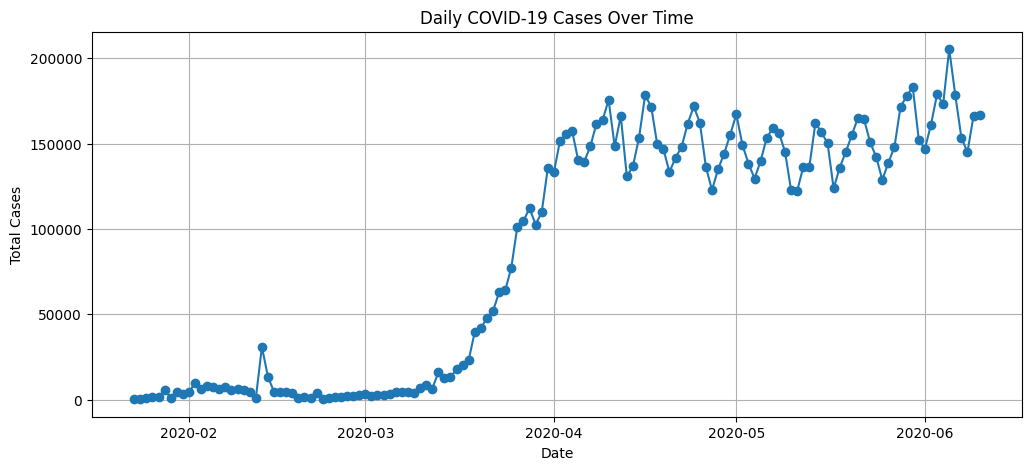

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
train_df['Date'] = pd.to_datetime(train_df['Date'])
daily_cases = train_df.groupby('Date')['TargetValue'].sum()

plt.figure(figsize=(12, 5))
plt.plot(daily_cases.index, daily_cases.values, marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.title("Daily COVID-19 Cases Over Time")
plt.grid()
plt.show()

In [49]:
train_df["County"].fillna("Unknown", inplace=True)
train_df["Province_State"].fillna("Unknown", inplace=True)

test_df["County"].fillna("Unknown", inplace=True)
test_df["Province_State"].fillna("Unknown", inplace=True)

<ipython-input-49-eaef242aeb5f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["County"].fillna("Unknown", inplace=True)
<ipython-input-49-eaef242aeb5f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [50]:
train_df["Prev_Day_Cases"] = train_df.groupby(["Country_Region", "Province_State", "County"])["TargetValue"].shift(1)
train_df["7_Day_Avg"] = train_df.groupby(["Country_Region", "Province_State", "County"])["TargetValue"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
train_df["7_Day_Avg"].fillna(train_df["Prev_Day_Cases"], inplace=True)
train_df["Cases_Per_Million"] = (train_df["TargetValue"] / train_df["Population"]) * 1_000_000

<ipython-input-50-9723dc331871>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["7_Day_Avg"].fillna(train_df["Prev_Day_Cases"], inplace=True)


In [51]:
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])
test_df = test_df.merge(
    train_df[["Date", "Country_Region", "Province_State", "County", "Prev_Day_Cases", "7_Day_Avg"]],
    on=["Date", "Country_Region", "Province_State", "County"], 
    how="left"
)
test_df["Cases_Per_Million"] = (test_df["Prev_Day_Cases"] / test_df["Population"]) * 1_000_000

In [21]:
print("Earliest date:", train_df["Date"].min())
print("Latest date:", train_df["Date"].max())

Earliest date: 2020-01-23 00:00:00
Latest date: 2020-06-10 00:00:00


In [22]:
total_days = (train_df["Date"].max() - train_df["Date"].min()).days
split_date = train_df["Date"].min() + pd.Timedelta(days=int(0.8 * total_days))  # 80% for training

print("Suggested split date:", split_date)

Suggested split date: 2020-05-13 00:00:00


In [ ]:
split_date = "2020-05-13"

train_data = train_df[train_df["Date"] < split_date]
val_data = train_df[train_df["Date"] >= split_date]

print(f"Train Data: {train_data.shape}, Validation Data: {val_data.shape}")

split_date = "2020-05-13"

train_df["Case_Growth_Rate"] = train_df["Prev_Day_Cases"] / (train_df["7_Day_Avg"] + 1)
train_df["Log_Cases"] = np.log1p(train_df["Prev_Day_Cases"])  
train_df["Day_of_Week"] = pd.to_datetime(train_df["Date"]).dt.dayofweek

train_df["Prev_Day_Cases"] = train_df["Prev_Day_Cases"].clip(lower=0)
train_df["TargetValue"] = train_df["TargetValue"].clip(lower=0)
train_df["Cases_Per_Million"] = train_df["Cases_Per_Million"].clip(lower=0)
train_df["Case_Growth_Rate"] = train_df["Case_Growth_Rate"].clip(-5, 5)  
train_df["Log_Cases"] = train_df["Log_Cases"].clip(0, 10)  
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)  
train_df.fillna(0, inplace=True)  

train_data = train_df[train_df["Date"] < split_date]
val_data = train_df[train_df["Date"] >= split_date]

features = ["Prev_Day_Cases", "7_Day_Avg", "Cases_Per_Million", "Case_Growth_Rate", "Log_Cases", "Day_of_Week"]

X_train, y_train = train_data[features], train_data["TargetValue"]
X_val, y_val = val_data[features], val_data["TargetValue"]
print(train_df.describe())

In [53]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
from sklearn.metrics import mean_absolute_error

In [55]:
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

print(f"Validation MAE: {mae:.4f}")

Validation MAE: 5.6721


In [62]:
test_df["Case_Growth_Rate"] = test_df["Prev_Day_Cases"] / (test_df["7_Day_Avg"] + 1)
test_df["Log_Cases"] = np.log1p(test_df["Prev_Day_Cases"])
test_df["Day_of_Week"] = pd.to_datetime(test_df["Date"]).dt.dayofweek

test_df["Prev_Day_Cases"] = test_df["Prev_Day_Cases"].clip(lower=0)
test_df["Cases_Per_Million"] = test_df["Cases_Per_Million"].clip(lower=0)
test_df["Case_Growth_Rate"] = test_df["Case_Growth_Rate"].clip(-5, 5)  
test_df["Log_Cases"] = test_df["Log_Cases"].clip(0, 10)  

test_df.replace([np.inf, -np.inf], np.nan, inplace=True) 
test_df.fillna(0, inplace=True)  

X_test = test_df[features]
test_df["Predicted_TargetValue"] = model.predict(X_test)

test_df[["ForecastId", "Date", "Predicted_TargetValue"]].to_csv("predictions.csv", index=False)
print(test_df[["ForecastId", "Date", "Predicted_TargetValue"]].head())

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


   ForecastId       Date  Predicted_TargetValue
0           1 2020-04-27              94.081100
1           1 2020-04-27               7.033216
2           2 2020-04-27              94.081100
3           2 2020-04-27               7.033216
4           3 2020-04-28             107.777779


In [64]:
features = ["Prev_Day_Cases", "7_Day_Avg", "Cases_Per_Million", "Case_Growth_Rate", "Log_Cases", "Day_of_Week"]
X_test = test_df[features]

predictions = model.predict(X_test)
quantiles = [0.05, 0.50, 0.95]
submission = []
for i, pred in enumerate(predictions):
    for q in quantiles:
        submission.append([f"{test_df.iloc[i]['ForecastId']}_{q:.2f}", pred])  

submission_df = pd.DataFrame(submission, columns=["ForecastId_Quantile", "TargetValue"])
submission_df.to_csv("submission.csv", index=False)
print(submission_df.head())

  ForecastId_Quantile  TargetValue
0              1_0.05    94.081100
1              1_0.50    94.081100
2              1_0.95    94.081100
3              1_0.05     7.033216
4              1_0.50     7.033216
